In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.3 MB 46 kB/s 
     |████████████████████████████████| 564 kB 25.5 MB/s 


In [ ]:
import numpy as np # for math operations with arrays
import pandas as pd # for table representations

import catboost
import catboost.datasets
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

В `catboost` встроено несколько демонстрационных датасетов. Они сложнее и на порядок больше, чем датасеты из `sklearn`.

---

## Постановка задачи

В этом дата сете приведены данные американского соцопроса 1994 года, задачей которого было исследовать, от чего зависит уровень дохода граждан. 

`Adult` -- традиционный датасет для иллюстрации бинарной классификации. Целевая переменная -- `income` -- имеет два значения: `<=50K` и `>50K`. Мы попробуем предсказать её, используя `catboost.CatBoostClassifier`. 

Обучение алгоритма будет происходить только на исходном наборе признаков.

## Описание данных

- `age` -- возраст в годах. Непрерывный признак. 

- `workclass` -- тип трудоустойства. Категориальный признак, множество допустимых значений: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

- `fnlwgt` -- он же `final weight`. Непрерывный признак, который представляет собой эдакую одномерную проекцию социодемографических признаков опрошенного человека: авторами датасета гарантируется, что у похожих людей будут похожие значения этого принзака. Полное описание приведено в конце раздела.

- `education` -- уровень полученного образования. Категориальный признак, множество допустимых  значений: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

- `education-num` -- количество лет обучения. Непрерывный признак. 

- `marital-status` -- семейное положение. Категориальный признак, множество допустимых значений: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

- `occupation` -- род занятий. Категориальный признак, множество значений: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

- `relationship` -- тоже семейное положение, но уже с акцентом на наличие / отсутствие детей. Категориальный признак, множество допустимых значений: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

- `race` -- раса. Датасет американский, а американцы уделяют этому гораздо больше внимания, чем стоило бы. :) Категориальный признак, множество допустимых значений: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

- `sex` -- пол. Категориальный признак, множество допустимых значений: Female, Male. 

- `capital-gain` -- суммарная прибыль от несвязанных с работой источников дохода (инвестиции, недвижимость etc) за последний год. Непрерывный призак.

- `capital-loss` -- суммарные убытки от несвязанных с работой источников дохода (инвестиции, недвижимость etc) за последний год. Непрерывный призак.

- `hours-per-week` -- количество рабочих часов в неделю. Непрерывный признак. 

- `native-country` -- страна происхождения. Категориальный признак, множество допустимых значений: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. Не очень понятно, зачем этот признак нужен, ведь там большая часть опрошенных из США, но что поделать.

In [ ]:
train_df, test_df = catboost.datasets.adult()

In [ ]:
print(
    '''
    Размеры выборок, (объекты, признаки).
    - Обучающая: {}
    - Тестовая: {}
    '''.format(
        train_df.shape,
        test_df.shape
    )
)


    Размеры выборок, (объекты, признаки).
    - Обучающая: (32561, 15)
    - Тестовая: (16281, 15)
    


In [ ]:
train_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [ ]:
train_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
 cat_features = [
    'workclass', 
    'education', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'native-country'
]

In [ ]:
for feature in cat_features:
    print(f'Feature {feature}')
    display(train_df[feature].value_counts())
    print('-' * 40)

Feature workclass


Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

----------------------------------------
Feature education


HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

----------------------------------------
Feature marital-status


Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

----------------------------------------
Feature occupation


Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

----------------------------------------
Feature relationship


Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

----------------------------------------
Feature race


White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

----------------------------------------
Feature sex


Male      21790
Female    10771
Name: sex, dtype: int64

----------------------------------------
Feature native-country


United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

----------------------------------------


In [ ]:
for df in [train_df, test_df]:
    df['is-immigrant'] = df['native-country'] == 'United-States'
    df.drop(columns=['native-country'], inplace=True)

In [ ]:
 cat_features = [
    'workclass', 
    'education', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'is-immigrant'
]

In [ ]:
train_df.isna().mean()

age               0.000000
workclass         0.056386
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.056601
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
is-immigrant      0.000000
dtype: float64

In [ ]:
test_df.isna().mean()

age               0.000000
workclass         0.059149
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.059333
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
is-immigrant      0.000000
dtype: float64

In [ ]:
train_df['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [ ]:
train_df_no_missing = train_df.dropna()
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train_df_no_missing.drop(columns=['income']),
    train_df_no_missing['income'],
    test_size=0.1,
    stratify=train_df_no_missing['income'],
    random_state=28
)

test_df_no_missing = test_df.dropna()
test_X = test_df_no_missing.drop(columns=['income'])
test_y = test_df_no_missing['income']

In [ ]:
?sns.catplot

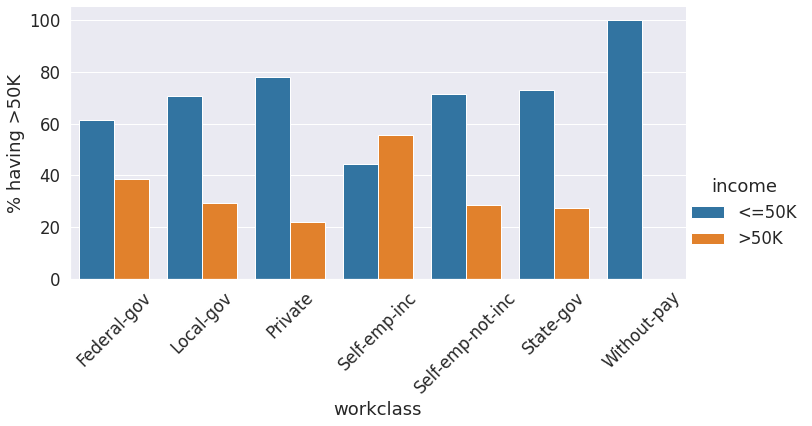

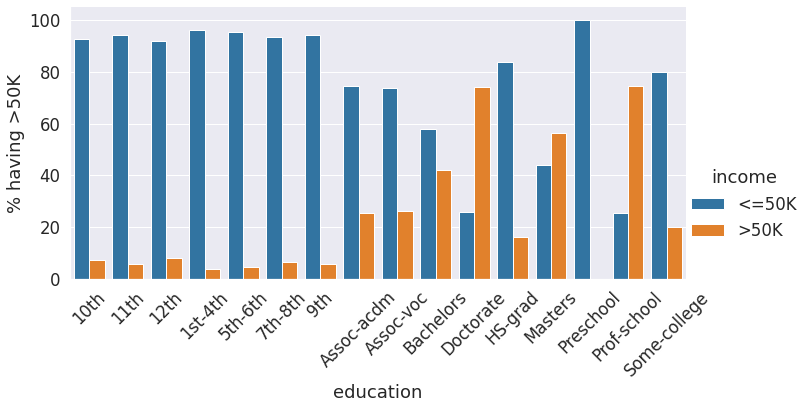

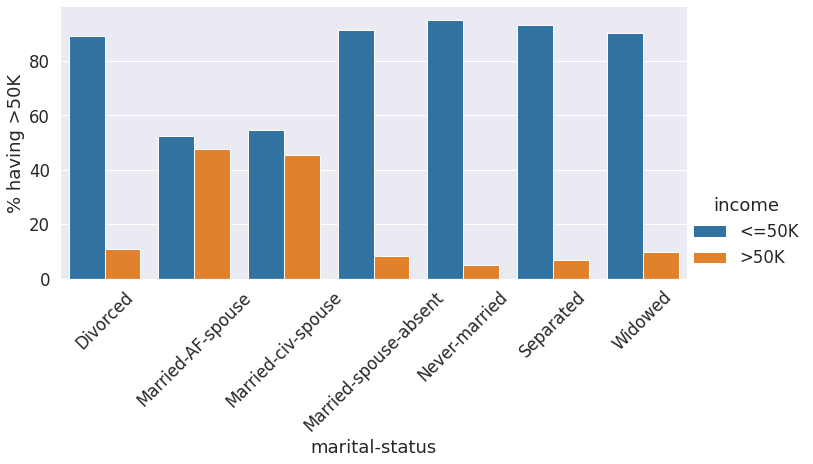

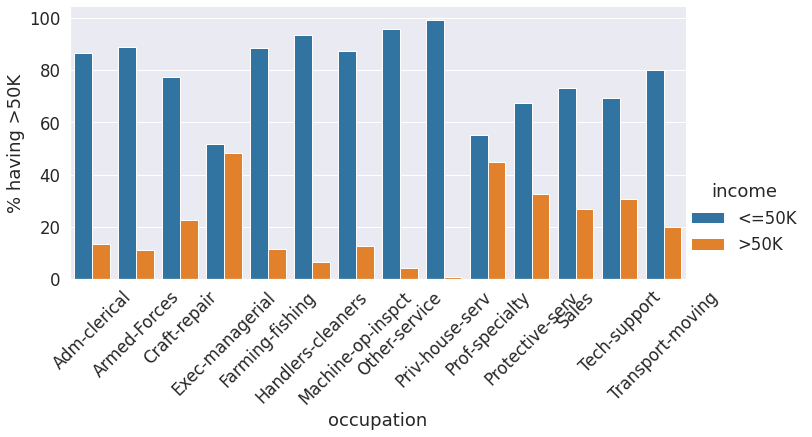

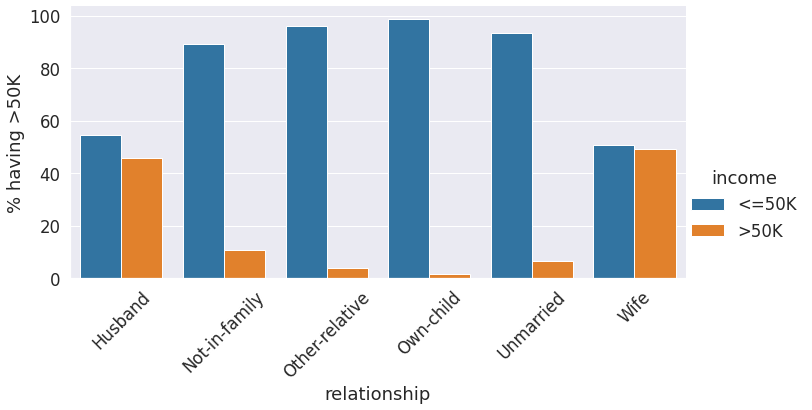

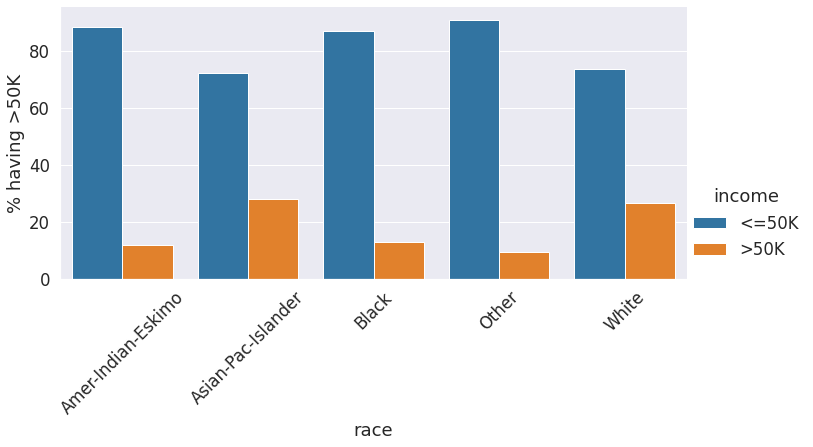

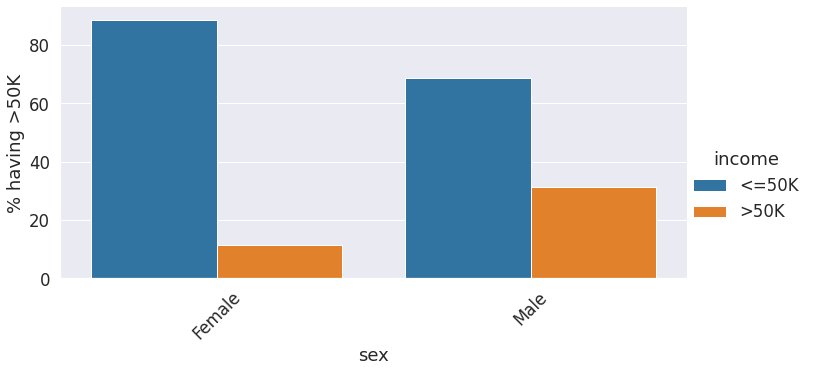

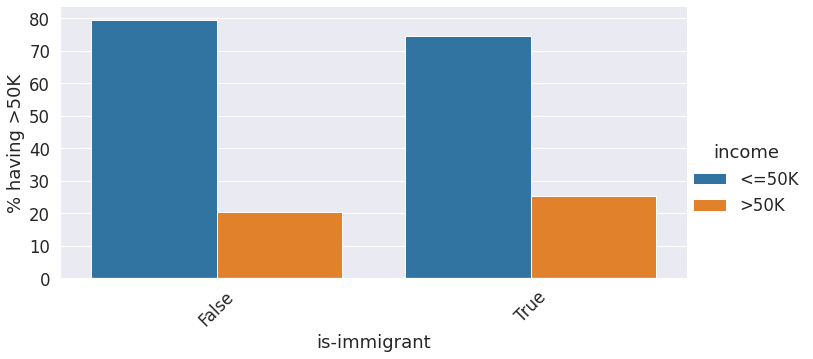

In [ ]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

    for feature in cat_features:
        tmp_df = (
            train_df_no_missing.groupby(feature)['income'].value_counts(
                normalize=True
            )
        )
        tmp_df = tmp_df.mul(100).rename('% having >50K').reset_index()
        g = sns.catplot(
            data=tmp_df,
            x=feature,
            y='% having >50K',
            kind='bar',
            hue='income',
            height=5,
            aspect=2,
        )
        g.ax.set_xticklabels(
            g.ax.get_xticklabels(), 
            rotation=45
        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



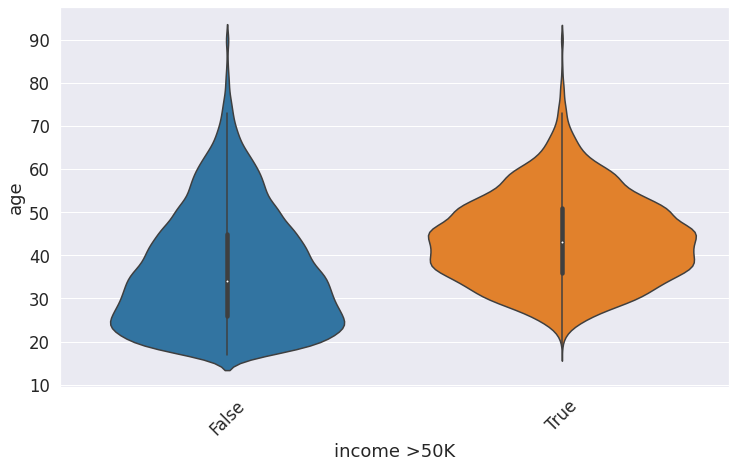

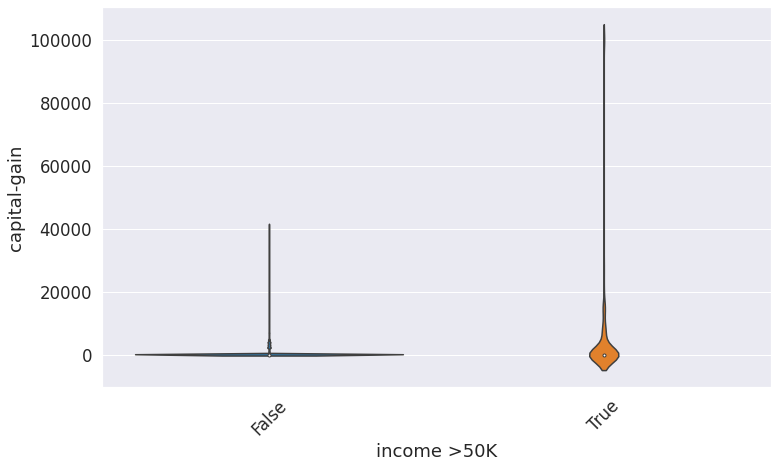

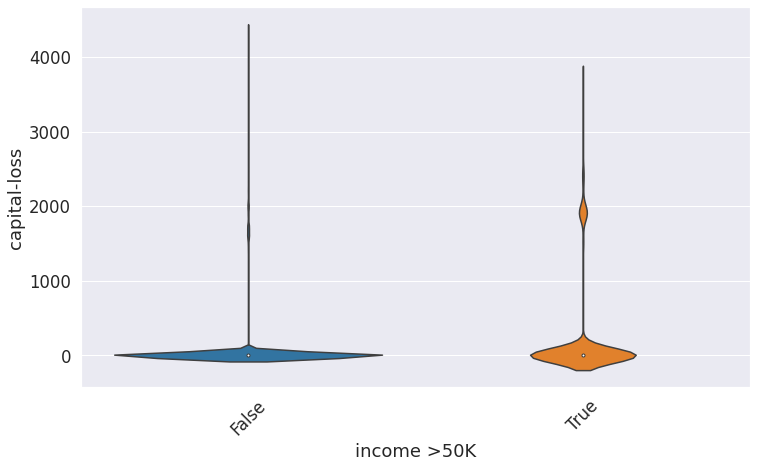

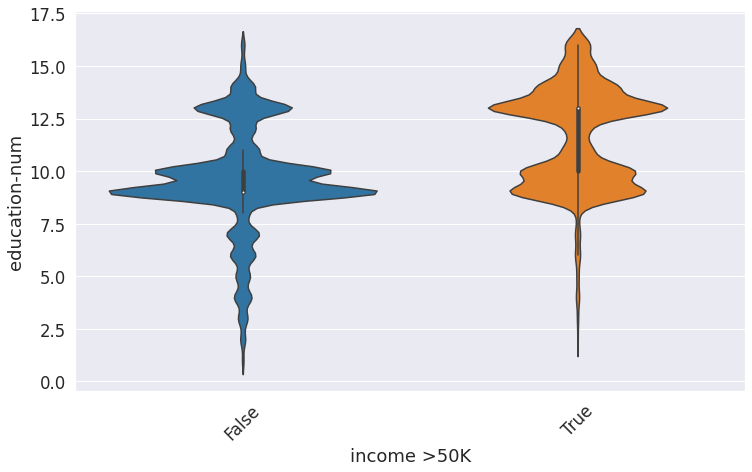

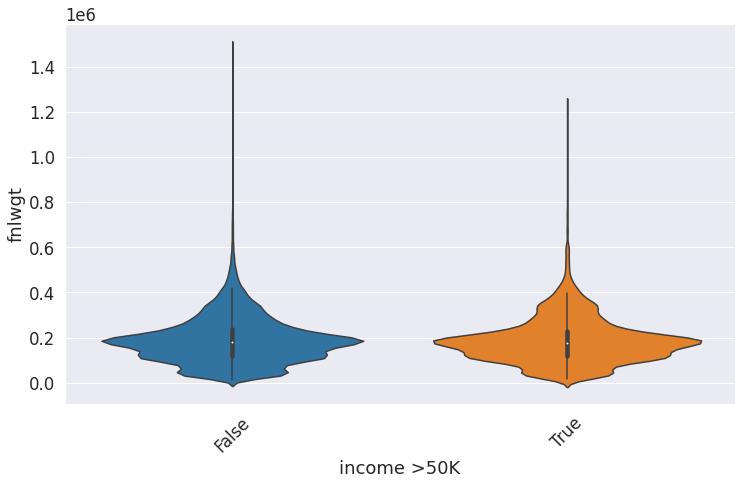

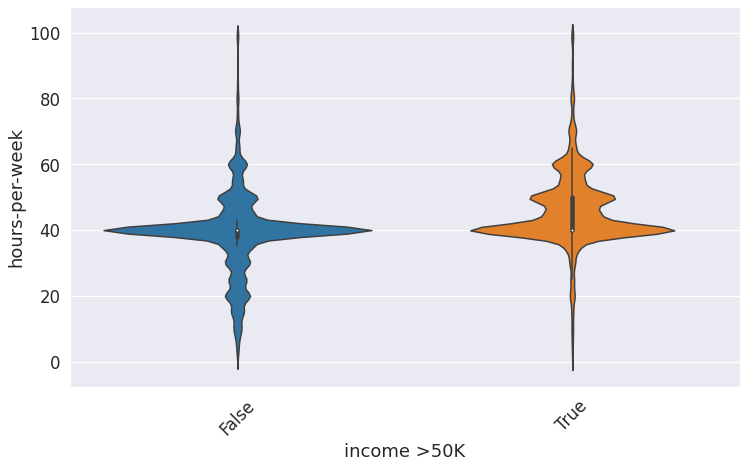

In [ ]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):
    train_df_no_missing['income >50K'] = (
        train_df_no_missing['income'] == '>50K'
    )
    for feature in np.setdiff1d(
        train_df.columns, 
        cat_features + ['income', 'income >50K']
    ): 
        fig, ax = plt.subplots(figsize=(12, 7))
        ax = sns.violinplot(
            data=train_df_no_missing,
            y=feature,
            x='income >50K',
            ax=ax
        )
        ax.set_xticklabels(
            ax.get_xticklabels(), 
            rotation=45
        )
        fig.show()

In [ ]:
train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    val_X,
    label=val_y,
    cat_features=cat_features
)
test_pool = catboost.Pool(
    test_X,
    label=test_y,
    cat_features=cat_features
)

In [ ]:
?catboost.CatBoostClassifier

In [ ]:
!rm -rf 'catboost_clf_on_adult/snapshot.bkp'

In [ ]:
catboost_train_dir = 'catboost_clf_on_adult'
clf = catboost.CatBoostClassifier(
    eval_metric='AUC',
    od_pval=0.05,
    od_wait=20,
    # early_stopping_rounds=20,
    random_seed=28,
    train_dir=catboost_train_dir,
    task_type='CPU',
    # task_type='GPU',
    # devices='0',
    auto_class_weights='Balanced',
    max_ctr_complexity=4,
    use_best_model=True
)
clf.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071944
0:	test: 0.8723564	best: 0.8723564 (0)	total: 111ms	remaining: 1m 51s
1:	test: 0.8842103	best: 0.8842103 (1)	total: 172ms	remaining: 1m 25s
2:	test: 0.8826354	best: 0.8842103 (1)	total: 238ms	remaining: 1m 19s
3:	test: 0.8868454	best: 0.8868454 (3)	total: 293ms	remaining: 1m 12s
4:	test: 0.8902734	best: 0.8902734 (4)	total: 357ms	remaining: 1m 11s
5:	test: 0.8946035	best: 0.8946035 (5)	total: 404ms	remaining: 1m 6s
6:	test: 0.8952203	best: 0.8952203 (6)	total: 453ms	remaining: 1m 4s
7:	test: 0.8973213	best: 0.8973213 (7)	total: 505ms	remaining: 1m 2s
8:	test: 0.8983341	best: 0.8983341 (8)	total: 555ms	remaining: 1m 1s
9:	test: 0.8994169	best: 0.8994169 (9)	total: 604ms	remaining: 59.8s
10:	test: 0.9002504	best: 0.9002504 (10)	total: 651ms	remaining: 58.5s
11:	test: 0.9006179	best: 0.9006179 (11)	total: 704ms	remaining: 58s
12:	test: 0.9012930	best: 0.9012930 (12)	total: 758ms	remaining: 57.5s
13:	test: 0.9017132	best: 0.9017132 (13)	total: 802ms	remaining:

In [ ]:
test_metrics = clf.eval_metrics(
    test_pool,
    metrics=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'],
    ntree_start=clf.best_iteration_ - 1,
    ntree_end=clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)

In [ ]:
test_metrics

{'AUC': [0.926308772243469],
 'Accuracy': [0.8424571276832906],
 'F1': [0.8434317169512147],
 'Precision': [0.8321873654717794],
 'Recall': [0.8549840933191941]}

In [ ]:
sorted(
    zip(train_X.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

[('capital-gain', 22.058777633047143),
 ('relationship', 16.236038369007233),
 ('age', 13.71055008265815),
 ('capital-loss', 7.687464054098279),
 ('occupation', 7.607498128931248),
 ('hours-per-week', 7.438981257631485),
 ('marital-status', 5.925255769979037),
 ('education-num', 5.2267457373334665),
 ('education', 4.187254408658098),
 ('fnlwgt', 3.377951742059446),
 ('workclass', 2.6734908572975407),
 ('sex', 1.730307949016058),
 ('race', 1.5677859676620325),
 ('is-immigrant', 0.5718980426207781)]